<a href="https://colab.research.google.com/github/AdrianCobo/Deep-Learning-And-Artificial-Intelligence/blob/main/L7_Text_Classification_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [36]:
# Unfortunately this URL doesn't work directly with pd.read_csv
!wget -nc https://lazyprogrammer.me/course_files/spam.csv

File ‘spam.csv’ already there; not retrieving.



In [37]:
# bad formatting!
!head spam.csv

v1,v2,,,
ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",,,
ham,Ok lar... Joking wif u oni...,,,
spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,,,
ham,U dun say so early hor... U c already then say...,,,
ham,"Nah I don't think he goes to usf, he lives around here though",,,
spam,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, �1.50 to rcv",,,
ham,Even my brother is not like to speak with me. They treat me like aids patent.,,,
ham,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune,,,
spam,WINNER!! As a valued network customer you have been selected to receivea �900 prize reward! To claim call 09061701461. Claim 

In [38]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')

In [39]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [40]:
# drop unnecesary columns
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

In [41]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [42]:
df.columns = ['labels', 'data']

In [43]:
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [44]:
# create binary labels
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})

In [45]:
df_train, df_test = train_test_split(df, test_size=0.33)

In [46]:
df_train.shape, df_test.shape

((3733, 3), (1839, 3))

In [47]:
# 0 = padding
idx = 1
word2idx = {'<PAD>': 0}

In [48]:
# you could always use gensim or spacy for tokenization,
# but let's keep it simple!
for i, row in df_train.iterrows():
  tokens = row['data'].lower().split() # simple tokenization(lower-> lowercase the text; split-> split phrase using spaces)
  for token in tokens:
    if token not in word2idx:
      word2idx[token] = idx
      idx += 1

In [49]:
word2idx

{'<PAD>': 0,
 'no': 1,
 'go.': 2,
 'openings': 3,
 'for': 4,
 'that': 5,
 'room': 6,
 "'til": 7,
 'after': 8,
 'thanksgiving': 9,
 'without': 10,
 'an': 11,
 'upcharge.': 12,
 "i'm": 13,
 'sick': 14,
 '!!': 15,
 'needy': 16,
 'i': 17,
 'want': 18,
 'you': 19,
 '*pouts*': 20,
 '*stomps': 21,
 'feet*': 22,
 'where': 23,
 'are': 24,
 '?!': 25,
 'my': 26,
 'slave': 27,
 'him': 28,
 'now': 29,
 'slept?': 30,
 'thinkthis': 31,
 'time': 32,
 '(': 33,
 '&lt;#&gt;': 34,
 'pm)': 35,
 'is': 36,
 'not': 37,
 'dangerous': 38,
 'pic.': 39,
 'please': 40,
 're-send.': 41,
 'do': 42,
 'i?': 43,
 'thought': 44,
 'put': 45,
 'it': 46,
 'back': 47,
 'in': 48,
 'the': 49,
 'box': 50,
 'mostly': 51,
 'sports': 52,
 'type..lyk': 53,
 'footbl,crckt..': 54,
 'haha': 55,
 'get': 56,
 'used': 57,
 'to': 58,
 'driving': 59,
 'usf': 60,
 'man,': 61,
 'know': 62,
 'a': 63,
 'lot': 64,
 'of': 65,
 'stoners': 66,
 'what': 67,
 'this': 68,
 "'hex'": 69,
 'place': 70,
 'talk': 71,
 'of?': 72,
 'explain!': 73,
 'free':

In [50]:
len(word2idx)

10613

In [51]:
# convert data into word indices
# note: could hae done this on the fly earlier
train_sentences_as_int = []
for i, row in df_train.iterrows():
  tokens = row['data'].lower().split()
  sentence_as_int = [word2idx[token] for token in tokens]
  train_sentences_as_int.append(sentence_as_int)

In [52]:
# convert data into word indices
# note: could hae done this on the fly earlier
test_sentences_as_int = []
for i, row in df_test.iterrows():
  tokens = row['data'].lower().split()
  sentence_as_int = [word2idx[token] for token in tokens if token in word2idx]
  test_sentences_as_int.append(sentence_as_int)

In [53]:
len(train_sentences_as_int), len(test_sentences_as_int)

(3733, 1839)

In [54]:
def data_generator(X, y, batch_size=32):
  X, y = shuffle(X,y)
  n_batches = int(np.ceil(len(y) / batch_size))
  for i in range(n_batches):
    end = min((i+1) * batch_size, len(y))

    X_batch = X[i * batch_size:end]
    y_batch = y[i * batch_size:end]

    # pad X_batch to be N x T
    max_len = np.max([len(x) for x in X_batch]) # all batches with the max size
    for j in range(len(X_batch)):
      x = X_batch[j]
      pad = [0] * (max_len - len(x))
      X_batch[j] = pad + x

      # convert to tensor
    X_batch = torch.from_numpy(np.array(X_batch)).long()
    y_batch = torch.from_numpy(np.array(y_batch)).long()

    yield X_batch, y_batch

In [55]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [56]:
# What is the shape of embedding output?
# N x T x D
embed = nn.Embedding(len(word2idx),20)
for inputs, targets in data_generator(train_sentences_as_int, df_train.b_labels):
  out = embed(inputs)
  print("Input shape:", inputs.shape)
  print("Output shape", out.shape)
  break

Input shape: torch.Size([32, 34])
Output shape torch.Size([32, 34, 20])


In [57]:
from numpy.core.numeric import outer
# Define the model
class CNN(nn.Module):
  def __init__(self, n_vocab, embed_dim, n_outputs):
    super(CNN, self).__init__()
    self.V = n_vocab
    self.D = embed_dim
    self.K = n_outputs

    # if input is T words
    # then outputs is (T, D) matrix
    self.embed = nn.Embedding(self.V, self.D)

    # conv layers
    self.conv1 = nn.Conv1d(self.D, 32, 3, padding=1)
    self.pool1 = nn.MaxPool1d(2)
    self.conv2 = nn.Conv1d(32, 64, 3, padding=1)
    self.pool2 = nn.MaxPool1d(2)
    self.conv3 = nn.Conv1d(64, 128, 3, padding=1)

    self.fc = nn.Linear(128, self.K)

  def forward(self, X):
    # embedding layers
    # turns word indexes into words vectors
    out = self.embed(X)

    # note: output of embedding is always
    # (N, T, D)
    # conv1d expects
    # (N, D, T)

    # conv layers
    out = out.permute(0, 2, 1)
    out = self.conv1(out)
    out = F.relu(out)
    out = self.pool1(out)
    out = self.conv2(out)
    out = F.relu(out)
    out = self.pool2(out)
    out = self.conv3(out)
    out = F.relu(out)

    # change it back
    out = out.permute(0, 2, 1)

    # max pool
    out, _ = torch.max(out, 1)

    # final dense layer
    out = self.fc(out)
    return out

In [58]:
model = CNN(len(word2idx), 20, 1)
model.to(device)

CNN(
  (embed): Embedding(10613, 20)
  (conv1): Conv1d(20, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [59]:
# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [60]:
train_gen = lambda: data_generator(train_sentences_as_int, df_train.b_labels)
test_gen = lambda: data_generator(test_sentences_as_int, df_test.b_labels)

In [61]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    t0 = datetime.now()
    train_loss = []
    for inputs, targets in train_gen():
      # print("inputs.shape:", inputs.shape, "targets.shape:", targets.shape)
      targets = targets.view(-1, 1).float()
      # move data to GPU
      inputs, targets = inputs.to(device), targets.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)

      # Backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss) # a little misleading

    test_loss = []
    for inputs, targets in test_gen():
      inputs, targets = inputs.to(device), targets.to(device)
      targets = targets.view(-1, 1).float()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses 
    train_losses[it] = train_loss
    test_losses[it] = test_loss

    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
      Test Loss: {test_loss:.4f}, Duration: {dt}')
  return train_losses, test_losses

In [62]:
train_losses, test_losses = batch_gd(
    model, criterion, optimizer, 15)

Epoch 1/15, Train Loss: 0.3889,       Test Loss: 0.3128, Duration: 0:00:01.425308
Epoch 2/15, Train Loss: 0.2493,       Test Loss: 0.1681, Duration: 0:00:01.310610
Epoch 3/15, Train Loss: 0.1370,       Test Loss: 0.1328, Duration: 0:00:01.338606
Epoch 4/15, Train Loss: 0.0913,       Test Loss: 0.1225, Duration: 0:00:01.311719
Epoch 5/15, Train Loss: 0.0625,       Test Loss: 0.1037, Duration: 0:00:01.274362
Epoch 6/15, Train Loss: 0.0425,       Test Loss: 0.1022, Duration: 0:00:01.294131
Epoch 7/15, Train Loss: 0.0294,       Test Loss: 0.1186, Duration: 0:00:01.314072
Epoch 8/15, Train Loss: 0.0203,       Test Loss: 0.1361, Duration: 0:00:01.352884
Epoch 9/15, Train Loss: 0.0144,       Test Loss: 0.1165, Duration: 0:00:02.532467
Epoch 10/15, Train Loss: 0.0082,       Test Loss: 0.1168, Duration: 0:00:02.539129
Epoch 11/15, Train Loss: 0.0057,       Test Loss: 0.1249, Duration: 0:00:01.290352
Epoch 12/15, Train Loss: 0.0044,       Test Loss: 0.1543, Duration: 0:00:01.296050
Epoch 13/15, 

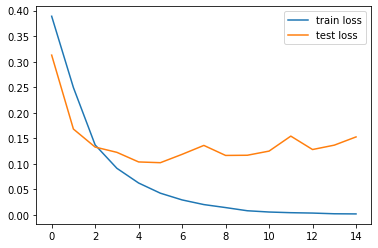

In [63]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [64]:
# Accuracy

n_correct = 0.
n_total = 0.
for inputs, targets in train_gen():
  targets = targets.view(-1, 1).float()
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  predictions = (outputs > 0)

  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total

n_correct = 0.
n_total = 0.
for inputs, targets in test_gen():
  targets = targets.view(-1, 1).float()
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  predictions = (outputs > 0)

  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9997, Test acc: 0.9755
